Based on 
Dhara, A and M.K. Sen, 2022, Physics-guided deep autoencoder to overcome the need
for a starting model in full-waveform inversion, The Leading Edge.

[https://doi.org/10.1190/tle41060375.1](https://doi.org/10.1190/tle41060375.1)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -r /content/drive/MyDrive/Colab\ Notebooks/pinn_fwi/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 4.6 MB/s 
     |████████████████████████████████| 934 kB 45.2 MB/s 
     |████████████████████████████████| 68 kB 7.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 84 kB 2.5 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 70 kB 9.4 MB/s 
     |████████████████████████████████| 120 kB 69.5 MB/s 
     |████████████████████████████████| 254 kB 68.1 MB/s 
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65034 sha256=9dab24f64f1d072c17b9b4f9bb21722c1e4db00520d1abf48283cb7f209edc96
  Stored in directory: /root/.cache/pip/wheels/37/5e/9e/76d743

In [3]:
# !ipython /content/drive/MyDrive/Colab\ Notebooks/pinn_fwi/d_obs_deepwave.py

In [4]:
import sys 
sys.path.append("/content/drive/MyDrive/Colab Notebooks/pinn_fwi/")


In [5]:
# sys.path.pop()

In [6]:
# sys.path

In [7]:
from config import *
from networks import Autoencoder

======= Package deepwave is used =========


In [8]:
d_obs = torch.load(
    f= PATH + "/data_model/taux_obs_" + PACKAGE + "_" + MODEL + "_" + str(N_SHOTS)
    )
# d_obs = data_normalization(d_obs)
d_obs = d_obs.unsqueeze(0).to(device=DEVICE)

print(d_obs.shape)

torch.Size([1, 60, 150, 447])


In [9]:
criteria = torch.nn.MSELoss(reduction='sum')

autoencoder = Autoencoder(batch_size=BATCH_SIZE, in_channels=N_SHOTS,
                  n_blocks_encoder=N_BLOCKS_ENCODER, n_blocks_decoder=N_BLOCKS_DECODER,
                  final_size_encoder=FINAL_SIZE_ENCODER, initial_shape_decoder=DECODER_INITIAL_SHAPE,
                  nt=NT, nr=N_RECEIVERS, final_spatial_shape=model_shape,
                  m_min=VP_MIN, m_max=VP_MAX,
                  final_out_channels=1
                  )
autoencoder = autoencoder.to(device=DEVICE)



In [10]:
optim_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, betas=(0.5, 0.9))
scheduler_autoencoder = torch.optim.lr_scheduler.StepLR(optim_autoencoder, 200, gamma=0.5)
all_loss = []
    

In [11]:
chp_path = PATH + "/results/iter_400_autoencoder_ns60_freqs_152560.pth.tar"
if chp_path:
  load_checkpoint(chp_path, autoencoder, device=DEVICE)

=> Loading checkpoint


In [ ]:
for iter in range(401, ITERATION):
    loss, m, autoencoder = train_fun(Physics=Physics, autoencoder=autoencoder,
                     d_obs=d_obs, freqs=INV_FREQS,
                     optim_autoencoder=optim_autoencoder, criteria=criteria,
                     mini_batches = MINI_BATCHES,
                     src_loc=src_loc, rec_loc=rec_loc, src=src,
                     inpa=inpa, test=None)
    
    all_loss.append(loss)
        
    if iter%25 == 0:
        print(f"Iteration {iter + 1} ===== loss: {all_loss[-1]}")
    if iter%100 == 0:
      file_name = PATH + "/results/iter_"+ str(iter) + "_autoencoder_ns60_freqs_152560.pth.tar"
      save_checkpoint(autoencoder, file_name)

      plt.figure()
      plt.imshow(m.cpu().detach(), cmap="jet")
      plt.colorbar()
    scheduler_autoencoder.step()



Iteration 1 ===== loss: 141.54246858755747
=> Saving checkpoint


Iteration 26 ===== loss: 64.53186247083876


Iteration 51 ===== loss: 72.19725530677371


Iteration 76 ===== loss: 47.017214159170784


Iteration 101 ===== loss: 53.713555504878364
=> Saving checkpoint


Iteration 126 ===== loss: 106.71665900283391


Iteration 151 ===== loss: 88.73635775513121


Iteration 176 ===== loss: 88.4714803033405


Iteration 201 ===== loss: 20.686602999766666
=> Saving checkpoint


Iteration 226 ===== loss: 23.19132845931583


Iteration 251 ===== loss: 18.930490735504364


Iteration 276 ===== loss: 22.60623972780175


Iteration 301 ===== loss: 18.52391727765401
=> Saving checkpoint


Iteration 326 ===== loss: 18.131774836116367


Iteration 351 ===== loss: 16.358415282434887


Iteration 376 ===== loss: 25.802657044596142


Iteration 401 ===== loss: 8.67380670706431
=> Saving checkpoint


 67%|██████▋   | 2/3 [00:49<00:24, 24.76s/it]

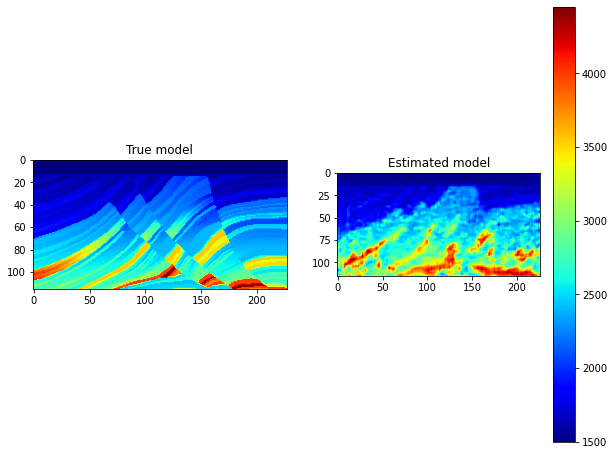

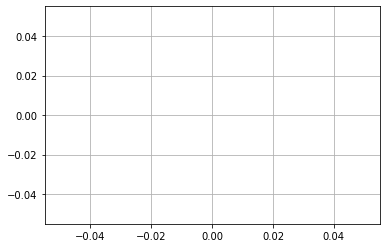

In [15]:
vp, _ = earth_model("marmousi_bl", smooth=15, device="cpu")
vp_min = vp.min()
vp_max = vp.max()

estimated = autoencoder(d_obs)[0,0, ...]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(121)
im = ax.imshow(vp, cmap="jet", vmin=vp_min, vmax=vp_max)
ax.set_title("True model")

ax = fig.add_subplot(122)
ax.imshow(estimated.cpu().detach(), cmap="jet")
ax.set_title("Estimated model")
plt.colorbar(im)

plt.figure()
plt.plot(all_loss)
plt.grid()


In [ ]:
file_name = PATH + "/results/"+ PACKAGE + "_autoencoder_ns60_freqs_152560.pth.tar"
save_checkpoint(autoencoder, file_name)

In [ ]:
from PyFWI.seismic_io import save_mat
save_mat(PATH + "/results/"+ PACKAGE, data={"m":m, "res":all_loss}, unique=True)

In [ ]:
d_obs.device

In [ ]:
len(all_loss)